<a href="https://colab.research.google.com/github/jessecanada/MAPS/blob/master/2.2.%20Training_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up the environment

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import ImageOps, Image, ImageEnhance
#from IPython.display import display
from google.colab import files
import cv2

In [0]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls drive/My\ Drive/data_augmentation

 bbox_util.py				 rotated_cell_obj_id_bbox.gsheet
 cell_obj_id_bbox.csv			 rotated_images.zip
'Copy of rotated_cell_obj_id_bbox.csv'	 training_images.zip
 data_aug.py				 transformed_cell_obj_id_bbox.csv
 images					 transformed_images.zip
 rotated_cell_obj_id_bbox.csv


In [0]:
# copy some stuff over
!cp drive/My\ Drive/data_augmentation/bbox_util.py ./
!cp drive/My\ Drive/data_augmentation/cell_obj_id_bbox.csv ./
!cp -r drive/My\ Drive/data_augmentation/images/ ./

In [0]:
# how many files are in the /images/ folder
!ls images | wc -l

148


In [0]:
# import useful tools from bbox_util
from bbox_util import *

## unzip training images into /images (if needed)

In [0]:
# Syntax: unzip {.zip-file-name} -d {/path/to/extract}
!unzip /content/drive/My\ Drive/data_augmentation/training_images.zip -d /content/

Archive:  /content/drive/My Drive/data_augmentation/training_images.zip
   creating: /content/images/
  inflating: /content/images/o-fca0eb709a5344edb8a054c756f1e8e2.jpg  
  inflating: /content/images/o-71ae342648894eed9dc52622f269afad.jpg  
  inflating: /content/images/o-a820ba5da0224a099fb7b1ecbb53adf6.jpg  
  inflating: /content/images/o-cf580be3fdae4d32aef63e04e42d4b41.jpg  
  inflating: /content/images/o-1e994d8807e34e2a975b8d62dbfa4a4c.jpg  
  inflating: /content/images/o-234217c0fe6048459ec3dae6a128c771.jpg  
  inflating: /content/images/o-3e9d9572797a45d1abfb5230ea35be42.jpg  
  inflating: /content/images/o-a6269b7730734ba98db26994aa8be2cd.jpg  
  inflating: /content/images/o-6b2857a5d4324906a291aac461bf85e7.jpg  
  inflating: /content/images/o-b5f3991fb2fe472eb690e0d43d979d9c.jpg  
  inflating: /content/images/o-66efdc9a0c104ac0b1af1177d3de869a.jpg  
  inflating: /content/images/o-8b503d94e095407a9e0f0d6b3167158c.jpg  
  inflating: /content/images/o-0640e1095bd7483ea8f18104f74

In [0]:
!mkdir drive/My\ Drive/data_augmentation/images

In [0]:
!cp -r images/*.jpg drive/My\ Drive/data_augmentation/images/

##A note on storage format
#####First things first, we define the storage formats required for images to work.
#####The Image: A OpenCV numpy array, of shape (H x W x C).
######Annotations: A numpy array of shape N x 5 where N is the number of objects, one represented by each row. 5 columns represent the top-left x-coordinate, top-left y-coordinate, bottom-right x-coordinate, bottom-right y-coordinate, and the class of the object.

##Some functions

#### not used

In [0]:
def create_bboxes_df(image_id, img_w, img_h, bboxes_processed, columns, process):
#     tag_dict_rev = {1: 'blob_clean',
#                     2: 'blob_noisy',
#                     3: 'blob_enclose'}
    tag_dict_rev = {0: 'furigana'}
    
    df_processed = pd.DataFrame(bboxes_processed)
    df_processed.columns = ['x1', 'y1', 'x2', 'y2', 'tag_int']
    df_processed['image_id'] = image_id + '-' + process
    df_processed['tag'] = df_processed['tag_int'].apply(lambda x: tag_dict_rev.get(x))
    df_processed['x'] = df_processed['x1'] / img_w
    df_processed['y'] = df_processed['y1'] / img_h
    df_processed['w'] = (df_processed['x2'] - df_processed['x1']) / img_w
    df_processed['h'] = (df_processed['y2'] - df_processed['y1']) / img_h
    df_processed = df_processed[columns]
    return df_processed

#### in use

In [0]:
def brightness_contrast_aug(img, cont_coeff=None, bright_coeff=None):
  """
  Given a PIL image, return an image with brightness /contrast enhanced,
  according to the given coefficient.
  
  Args:
    img (PIL Image): image to be brightness/contrast enhanced.
    cont_coeff (float): contrast coefficient, 0~1, lower number lighter contrast
    bright_coeff (float): brightness coefficient, 0~1, lower number darker brightness
  Returns:
    numpy.array('uint8'): return image in numpy format
  """
  img_bc = Image.fromarray(img.copy())

  if cont_coeff:
    cont_coeff = np.round(cont_coeff, 2)
    enhance_cont = ImageEnhance.Contrast(img_bc)
    img_bc = enhance_cont.enhance(cont_coeff)
  if bright_coeff:
    bright_coeff = np.round(bright_coeff, 2)
    enhance_bright = ImageEnhance.Brightness(img_bc)
    img_bc = enhance_bright.enhance(bright_coeff)
    
  return np.array(img_bc)

In [0]:
def rotate(image, angle, df_bboxes):
  """
  dependency: bbox_util
  df_bboxes = ['x1','y1','x2','y2','img_h','img_w']]
  """
  # rotate image
  rotated_img = rotate_im(image, angle)    

  # rotate bboxes
  df_img_wh = df_bboxes[['img_h', 'img_w']].reset_index(drop=True)
  df_bboxes.drop(['img_h', 'img_w'], axis=1, inplace=True)

  w,h = df_img_wh.img_w[0], df_img_wh.img_h[0]
  cx, cy = w//2, h//2 # coordinates of the centre of the image, about which bboxes will be rotated
  bboxes_array = df_bboxes.to_numpy() # turn df_bboxes into array
  
  corners = get_corners(bboxes_array)
  rotated_corners = rotate_box(corners, angle, cx, cy, h, w)
  rotated_bboxes = get_enclosing_box(rotated_corners)
  
  # turn rotated_bboxes from array into df
  df_rotated_bboxes = pd.DataFrame(data = rotated_bboxes[0:, 0:],
                                index = [i for i in range(rotated_bboxes.shape[0])],
                                columns = ['x1','y1','x2','y2'])
  df_rotated_bboxes = pd.concat([df_rotated_bboxes, df_img_wh], axis=1, sort=False)

  return rotated_img, df_rotated_bboxes

In [0]:
import matplotlib.patches as patches
def draw_rectangles(i, img_height, img_width, df_bboxes):
  """
  df_bboxes will need the following features: x1, y1, x2, y2, img_h, img_w
  """
  x = df_bboxes.x1[i]/df_bboxes.img_w[i]*img_width
  y = df_bboxes.y1[i]/df_bboxes.img_h[i]*img_height
  w = abs(df_bboxes.x2[i] - df_bboxes.x1[i])/df_bboxes.img_w[i]*img_width
  h = abs(df_bboxes.y2[i] - df_bboxes.y1[i])/df_bboxes.img_h[i]*img_height
  
  rectangles = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='w',facecolor='none')
  
  return rectangles

## practice adding noises

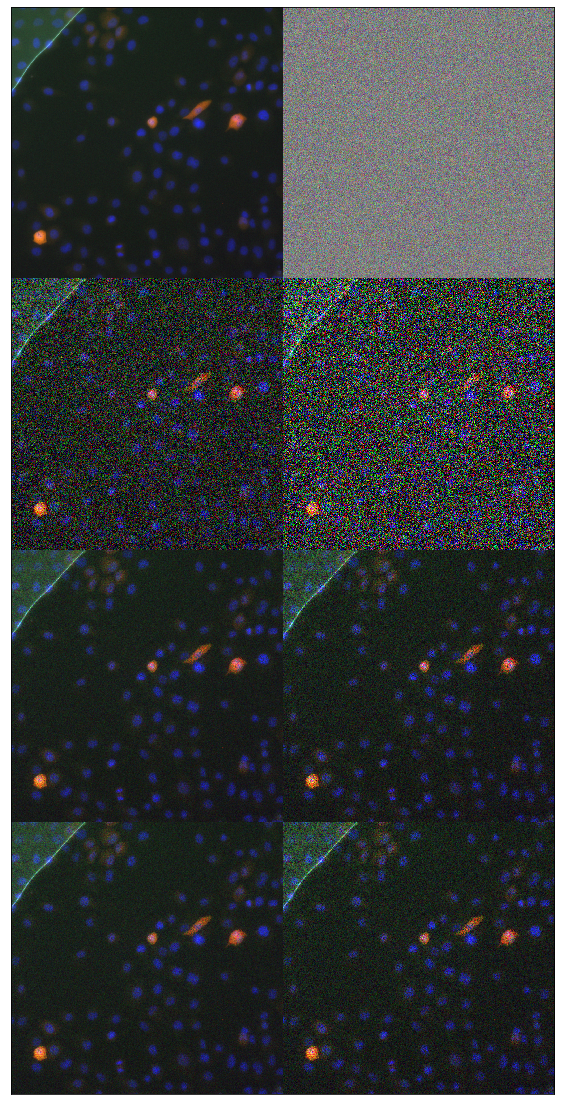

In [0]:
img = cv2.imread("images/o-15067467e8124e108e3a41460d4835ff.jpg", -1)[...,::-1]/255.0
noise =  np.random.normal(loc=0, scale=1, size=img.shape)

# noise overlaid over image
noisy = np.clip((img + noise*0.2),0,1)
noisy2 = np.clip((img + noise*0.4),0,1)

# noise multiplied by image:
# whites can go to black but blacks cannot go to white
noisy2mul = np.clip((img*(1 + noise*0.2)),0,1)
noisy4mul = np.clip((img*(1 + noise*0.4)),0,1)

# noise multiplied by bottom and top half images,
# whites stay white blacks black, noise is added to center
img2 = img*2
n2 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.2)), (1-img2+1)*(1 + noise*0.2)*-1 + 2)/2, 0,1)
n4 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.4)), (1-img2+1)*(1 + noise*0.4)*-1 + 2)/2, 0,1)

# norm noise for viz only
noise2 = (noise - noise.min())/(noise.max()-noise.min())

# plotting
plt.figure(figsize=(20,20))
plt.imshow(np.vstack((np.hstack((img, noise2)),
                      np.hstack((noisy, noisy2)),
                      np.hstack((noisy2mul, noisy4mul)),
                      np.hstack((n2, n4)))))
plt.xticks([]),plt.yticks([]) #hide ticks
plt.show()

## Testing bbox drawing function

In [0]:
# set up dataframe
d = pd.read_csv('cell_obj_id_bbox.csv')
print(d.head())

                             image_id   tag  tag_int  ...          y2  img_h  img_w
0  o-7023f07428e642bbbdb5a886a7f93358  cell        0  ...  670.807557    900    900
1  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  701.789461    900    900
2  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  842.571574    900    900
3  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  121.700115    900    900
4  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  351.510120    900    900

[5 rows x 13 columns]


In [0]:
import matplotlib.patches as patches
def draw_bboxes(img, img_height, img_width, bbox_df):
  """
  bbox_df will need the following features: x, y, w, h
  x, y are relative coordinates of the bboxes to the left and top of img
  w, h are width and height of bboxes
  """

  # Create figure and axes
  fig, ax = plt.subplots(1, 1, figsize=(4,4))

  # Display the image
  ax.imshow(img[:,:,[2,1,0]]) # openCV loads img in bgr, this converts img to rgb for matplotlib

  # Create rectangle patches
  for i in range(len(bbox_df)):
    y = int(img_height * bbox_df.y[i])
    h = int(img_height * bbox_df.h[i])
    x = int(img_width * bbox_df.x[i])
    w = int(img_width * bbox_df.w[i])
    
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='w',facecolor='none')
    
    ax.add_patch(rect) # Add the patch to the Axes
  
  return fig, ax

o-7023f07428e642bbbdb5a886a7f93358
iteration: 0


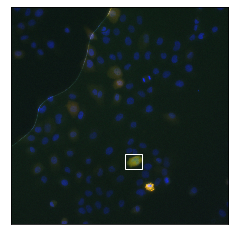

o-cd9a98df36794c3db7cbadda31c20745
iteration: 1
o-c7be42bb64d242a284a9f3fc17c7a76c
iteration: 2
o-1fa23e0b71134a8e9795160c425907e6
iteration: 3
o-9f713f6c539247588a71a0fe3c943b81
iteration: 4
o-6e03283fad0c41ce91297245a811cdaa
iteration: 5
o-1487c2fa6b944fe3ab6db00f4756b315
iteration: 6
o-0640e1095bd7483ea8f18104f74792ff
iteration: 7
o-2d5c34b6c69b4526bfbf71001b096cf2
iteration: 8
o-d214e54d4db24f5d8ca3a91eafc6c23f
iteration: 9
o-cd11e7361496405fb4cc13c3ca266961
iteration: 10
o-fdf3e90f82dc477099721050fa08e37b
iteration: 11
o-361c00ff1c5845aebfec5e7ca053d4e3
iteration: 12
o-b1e574758fb744d9889088535dcae857
iteration: 13
o-20a3e00a273247d299cf711cb2e1353a
iteration: 14
o-3f7ebebfad3441b3b07eb9e59db9add2
iteration: 15
o-2da398418fd74b8da80ce7ff7b6064a5
iteration: 16
o-683788fa1a8848e8ad34a1bb446251b4
iteration: 17
o-dd4bd8141cb84f119e15014da80d8677
iteration: 18
o-53b1790d203a4f3dae2f26912ce67de6
iteration: 19
o-4065aec856274e75972fb6df902de7f0
iteration: 20


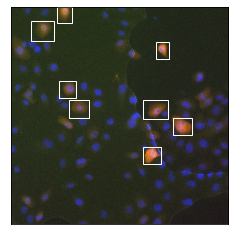

o-91a1f09556e14c03b9861e68f5146e7c
iteration: 21
o-8525a5311e764f84a2f86733f4e15f1c
iteration: 22
o-a21a4ae8684b491b8a9ddf705b4eef89
iteration: 23
o-965c8171ba494c669756719e67ffec7e
iteration: 24
o-8246969ac41e49f0a173b4eb439b6b65
iteration: 25
o-149a34b0696640d19ccbb5bbc0df36a5
iteration: 26
o-400573c4fd79480aadeb582c50350be3
iteration: 27
o-c4263616dcc948c6a668a6f7f7cdb1fd
iteration: 28
o-f9f829d9b61f4426b43f2e3c3396d20a
iteration: 29
o-e47e6ef714b0476fa67cb30afa3c8077
iteration: 30
o-4b32c746825648fc926bf537bfb94958
iteration: 31
o-cf580be3fdae4d32aef63e04e42d4b41
iteration: 32
o-106651c0bc454620902dca3a71ac1b8a
iteration: 33
o-fca0eb709a5344edb8a054c756f1e8e2
iteration: 34
o-c0e617c56dca41628f558b3e2baa7057
iteration: 35
o-26e84fc19e0140f1a2a2ce161b20e6d9
iteration: 36
o-f352a0ae96ad40c8a771ce537012b99e
iteration: 37
o-1c025f3fa8744a0a92f733910dbffb93
iteration: 38
o-14410e32e2b847e0acec2d2da5217ac9
iteration: 39
o-857b99b07ba3447891ba5189e4e61114
iteration: 40


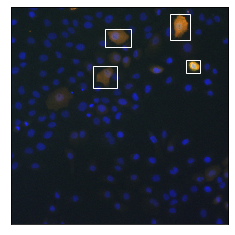

o-1bd92f1fdd1e4ba0817a8b9202dd39b9
iteration: 41
o-8aeba2dcf232409784e6cbec743a8e52
iteration: 42
o-798a522555d84b0cbaf8c9f021784e7f
iteration: 43
o-6e0d9b97264c46b8a2fcd313f6de16a5
iteration: 44
o-c02571a4af194cd8898a2cedbcbdba6d
iteration: 45
o-d766140594064838ad03f1bf4157d0c0
iteration: 46
o-4ef3a2d5602f41cd9760189493fdbc73
iteration: 47
o-aa9931ba8fa6416eb01b6d13ae29cd21
iteration: 48
o-bc6a280676604cf3a129f4466d5dd38e
iteration: 49
o-8534388a8fe04a65a019957e11ec22fa
iteration: 50
o-fd8cfc931fc444ee8bacfb72e8e6c295
iteration: 51
o-446ad5f7cd5344a3a42a4e4067323393
iteration: 52
o-d142889cae7b40bd865dd51b949a8cd3
iteration: 53
o-2aa3e30423cf4712949713d6bd8789f2
iteration: 54
o-68360aa25cff4a9e8bb5991c1d0385b6
iteration: 55
o-6baf452292274134b30eb08e832a74b7
iteration: 56
o-71ae342648894eed9dc52622f269afad
iteration: 57
o-50a638254a51442c9ed688272604b54c
iteration: 58
o-b50370aa739f4c94b39e4bb8c9adb330
iteration: 59
o-f7fec5a700d8483ea97698e1e9a022ff
iteration: 60


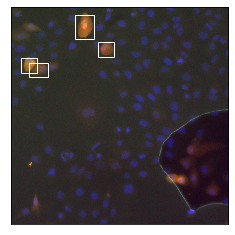

o-348ceb9566a44f6cb91e40a2b8cf0658
iteration: 61
o-6ac3cca1d3134974a0b6ff342d14fd28
iteration: 62
o-008fd610627047dab354a3f716063503
iteration: 63
o-7598ec672d7f487195a7ab9197bce711
iteration: 64
o-7a64e5aef8474fafa8a284cf1a0cccb5
iteration: 65
o-93e14a14c5854b5f815d97adb174ec0e
iteration: 66
o-8650bc1ffc3a49bca30e6eb21d6abd44
iteration: 67
o-5f4e1cede3864ddcbaeb3bb4f4789f14
iteration: 68
o-c52d12fcc363465f8d51430da3346f5d
iteration: 69
o-7633d8b70edb4bf38dc060d6aaf9f43c
iteration: 70
o-6b2857a5d4324906a291aac461bf85e7
iteration: 71
o-a6269b7730734ba98db26994aa8be2cd
iteration: 72
o-76479ffc21b54d04b2d8fef3fb1a26ab
iteration: 73
o-b2cc89a790ea4e79a3c9d9c2b09b147c
iteration: 74
o-7f6f226993124f5c8acd1ebdb8e0cf83
iteration: 75
o-1e994d8807e34e2a975b8d62dbfa4a4c
iteration: 76
o-15067467e8124e108e3a41460d4835ff
iteration: 77
o-2c1c3e46a7354ee49ac761b8dbdf700a
iteration: 78
o-b5f3991fb2fe472eb690e0d43d979d9c
iteration: 79
o-e2473994eb0a4e01808a58b778bcc780
iteration: 80


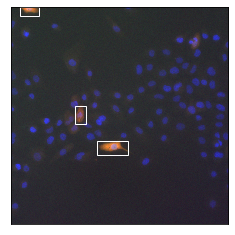

o-e4664ea1b47e4833a7fd7bde1c04440e
iteration: 81
o-818ade2f13bb4ec9a3233a45c6026bb0
iteration: 82
o-377dee25ec944df9bc9f510a7154c30e
iteration: 83
o-7661dc78d7164014bbb963a9efed8bb9
iteration: 84
o-3f4b62fb9b04401aa6ef92ed08423453
iteration: 85
o-74f06f467e1749e8b7aeb1ef1ece9a0b
iteration: 86
o-3f558a30d83e4fbe86aa456e182a3f07
iteration: 87
o-2c5bd9ca32714ad0ad24c9a1ce622eb9
iteration: 88
o-58b248bb2cec44e5ad7037fff063526f
iteration: 89
o-e9796f241c0d4c709f1587ff1bfcb143
iteration: 90
o-a9362a601f67477ea9199f854b68801b
iteration: 91
o-9ff930ee37fc42c3a92053434d8cc3ea
iteration: 92
o-619c84a5f515444cbfe60e125eef4f7b
iteration: 93
o-58c4411ffe80456db96e59cec80d0b2b
iteration: 94
o-c15f881ffd354e889611ae915376cc1d
iteration: 95
o-8dfe61bd976f4cbd8d0ff62b8100322e
iteration: 96
o-27776c5478544ea4bdcc31722452c384
iteration: 97
o-a44afc59f17e45eeb8901584bce6ec11
iteration: 98
o-66efdc9a0c104ac0b1af1177d3de869a
iteration: 99
o-c4fd419cdf224139a98378015f0d305a
iteration: 100


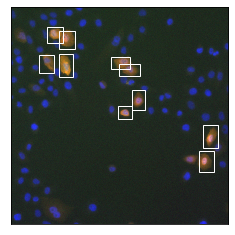

o-f674ca8fc0f24554a10fc457124a4e8d
iteration: 101
o-fb8f25b4cb3b4b65804bcbaedae192f0
iteration: 102
o-dbf1026ba7f94dc4aa7e480d287e084c
iteration: 103
o-6d547c1a476a4b56a34ef534fa379e88
iteration: 104
o-9a9f5d7ad8a04c75ad9765f6ad405b4c
iteration: 105
o-7f178557c8164dc0b8bc0013c6fcba06
iteration: 106
o-c90d6ccfa412423fa49363b87f4e8706
iteration: 107
o-2395db45f6f142c7a41c6d9cd703d97a
iteration: 108
o-44305b1c763d432788fcbe68038a4681
iteration: 109
o-b84669e6c077458f8d54e18c0fabe960
iteration: 110
o-6f4bba3e30e24322966b41e68afa8203
iteration: 111
o-b0c41d67a1a04482934ecbb9fb87a5ee
iteration: 112
o-6519422711584b858fa935015d539d7f
iteration: 113
o-ced85a99a2d44570b93724054ffa1e8f
iteration: 114
o-e0d0bb20f56942a9bee6d9d9b5e7a2c5
iteration: 115
o-779616d087424e3598100a0f9a06483e
iteration: 116
o-fb0c829d3a024e2a8df6a947cfb37975
iteration: 117
o-8b503d94e095407a9e0f0d6b3167158c
iteration: 118
o-c77401be84094dfaaea7514b34d3cf3d
iteration: 119
o-a820ba5da0224a099fb7b1ecbb53adf6
iteration: 120


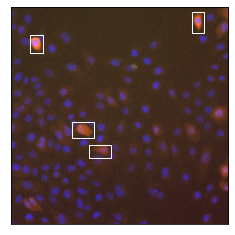

o-3d244fb72f1840e186dbb634f9f3c219
iteration: 121
o-2016cb3ca9b849859ef01fa56b49d833
iteration: 122
o-0806796b4d1948a3a658006754fb3f65
iteration: 123
o-2b863568c23d4ba28d2c27de49a2a7a9
iteration: 124
o-84cc86174b6748c5bf4af15ffa6d5dda
iteration: 125
o-f5dd5bfb002a4359a38311a39426b69f
iteration: 126
o-71916403b6f44e3492ba8aff59df912e
iteration: 127
o-51de745e5eed4c28a0c4be0aa0d379a9
iteration: 128
o-470a601b4ca14a54977b580466770bfb
iteration: 129
o-21347684342249d1aee35d7a234842e3
iteration: 130
o-f54829baf5ba4a94a16569f70d0608a1
iteration: 131
o-c31240915e9c45ed95d9fa83f027d40e
iteration: 132
o-424f371276974c5eac069e422b507947
iteration: 133
o-230eeea57d804e5bb2393f9c97f67c6d
iteration: 134
o-9cd9d7e0f9cf44f9a8cb768deb38f4fa
iteration: 135
o-23ecb1738e3c4697a2846f2191da8cc5
iteration: 136
o-074c5f7b727744ee80e4eec3134e3e6d
iteration: 137
o-234217c0fe6048459ec3dae6a128c771
iteration: 138
o-0a530e889c9c470db37df49d50c5a9a8
iteration: 139
o-3e9d9572797a45d1abfb5230ea35be42
iteration: 140


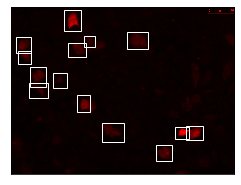

o-d3982c3408c84144b20ddd03a3458c44
iteration: 141
o-c4d0255d1396491584a51323400b39c3
iteration: 142
o-bb62637c28054242b594632e6557b103
iteration: 143
o-df3b211f62a54bc09847bb36dbd427b0
iteration: 144
o-dcedfca53dbf4afea707f526436b4257
iteration: 145
o-703e8579503d49e089863e1a4ab72ffc
iteration: 146
o-db4a780c771a4d08824eb83bf976c520
iteration: 147


In [0]:
# testing the bbox drawing function
plot_interval = 20
work_dir = 'images/'

for i, image_id in enumerate(d['image_id'].unique()):
  print(image_id)
  print(f'iteration: {i}')
  image = cv2.imread(f'{work_dir}{image_id}.jpg', -1)
  img_height, img_width, img_channel = image.shape

  bbox_df = d.loc[d['image_id'] == image_id, ['x', 'y', 'w', 'h']].reset_index(drop=True)
  #print(bbox_df.head(), '\n')

  # plot the iamge w/ bboxes
  if i % plot_interval == 0:
    fig, ax = draw_bboxes(image, img_height, img_width, bbox_df)
    plt.xticks([]), plt.yticks([]); plt.show(); plt.close()

## Perform transformations

In [0]:
!mkdir transformed_images/
!mkdir rotated_images/

In [0]:
# set up dataframe
d = pd.read_csv('cell_obj_id_bbox.csv')
print(d.head())
print('\n', f'Total number of bboxes = {len(d)}')

                             image_id   tag  tag_int  ...          y2  img_h  img_w
0  o-7023f07428e642bbbdb5a886a7f93358  cell        0  ...  670.807557    900    900
1  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  701.789461    900    900
2  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  842.571574    900    900
3  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  121.700115    900    900
4  o-cd9a98df36794c3db7cbadda31c20745  cell        0  ...  351.510120    900    900

[5 rows x 13 columns]

 Total number of bboxes = 752


In [0]:
loc_mask = (d['image_id'] == 'o-cd9a98df36794c3db7cbadda31c20745')
#d.loc[loc_mask, :].iloc[:, 1:]
d.loc[loc_mask, :].drop('image_id', axis=1).reset_index(drop=True)

tag  tag_int         x         y  ...          x2          y2  img_h  img_w
0  cell        0  0.635184  0.662448  ...  657.140373  701.789461    900    900
1  cell        0  0.625873  0.854254  ...  675.576116  842.571574    900    900
2  cell        0  0.782790  0.059747  ...  785.628509  121.700115    900    900
3  cell        0  0.720845  0.319803  ...  717.475581  351.510120    900    900
4  cell        0  0.354713  0.429032  ...  381.395962  454.282685    900    900

[5 rows x 12 columns]


 file: o-7023f07428e642bbbdb5a886a7f93358
iteration: 0


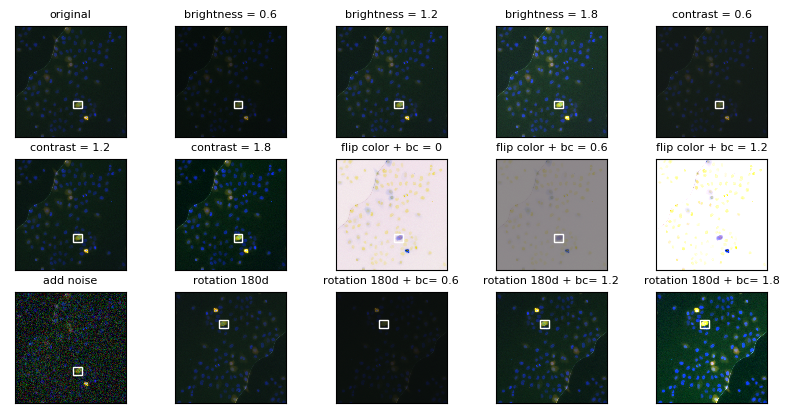


 file: o-cd9a98df36794c3db7cbadda31c20745
iteration: 1

 file: o-c7be42bb64d242a284a9f3fc17c7a76c
iteration: 2

 file: o-1fa23e0b71134a8e9795160c425907e6
iteration: 3

 file: o-9f713f6c539247588a71a0fe3c943b81
iteration: 4

 file: o-6e03283fad0c41ce91297245a811cdaa
iteration: 5

 file: o-1487c2fa6b944fe3ab6db00f4756b315
iteration: 6

 file: o-0640e1095bd7483ea8f18104f74792ff
iteration: 7

 file: o-2d5c34b6c69b4526bfbf71001b096cf2
iteration: 8

 file: o-d214e54d4db24f5d8ca3a91eafc6c23f
iteration: 9

 file: o-cd11e7361496405fb4cc13c3ca266961
iteration: 10

 file: o-fdf3e90f82dc477099721050fa08e37b
iteration: 11

 file: o-361c00ff1c5845aebfec5e7ca053d4e3
iteration: 12

 file: o-b1e574758fb744d9889088535dcae857
iteration: 13

 file: o-20a3e00a273247d299cf711cb2e1353a
iteration: 14

 file: o-3f7ebebfad3441b3b07eb9e59db9add2
iteration: 15

 file: o-2da398418fd74b8da80ce7ff7b6064a5
iteration: 16

 file: o-683788fa1a8848e8ad34a1bb446251b4
iteration: 17

 file: o-dd4bd8141cb84f119e15014da80d86

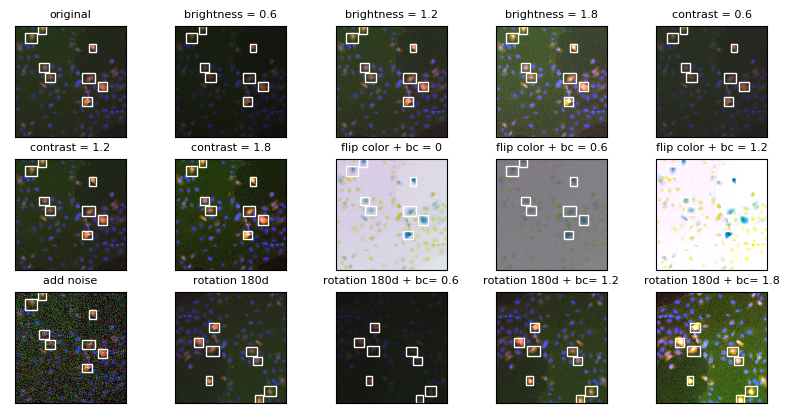


 file: o-91a1f09556e14c03b9861e68f5146e7c
iteration: 21

 file: o-8525a5311e764f84a2f86733f4e15f1c
iteration: 22

 file: o-a21a4ae8684b491b8a9ddf705b4eef89
iteration: 23

 file: o-965c8171ba494c669756719e67ffec7e
iteration: 24

 file: o-8246969ac41e49f0a173b4eb439b6b65
iteration: 25

 file: o-149a34b0696640d19ccbb5bbc0df36a5
iteration: 26

 file: o-400573c4fd79480aadeb582c50350be3
iteration: 27

 file: o-c4263616dcc948c6a668a6f7f7cdb1fd
iteration: 28

 file: o-f9f829d9b61f4426b43f2e3c3396d20a
iteration: 29

 file: o-e47e6ef714b0476fa67cb30afa3c8077
iteration: 30

 file: o-4b32c746825648fc926bf537bfb94958
iteration: 31

 file: o-cf580be3fdae4d32aef63e04e42d4b41
iteration: 32

 file: o-106651c0bc454620902dca3a71ac1b8a
iteration: 33

 file: o-fca0eb709a5344edb8a054c756f1e8e2
iteration: 34

 file: o-c0e617c56dca41628f558b3e2baa7057
iteration: 35

 file: o-26e84fc19e0140f1a2a2ce161b20e6d9
iteration: 36

 file: o-f352a0ae96ad40c8a771ce537012b99e
iteration: 37

 file: o-1c025f3fa8744a0a92f73

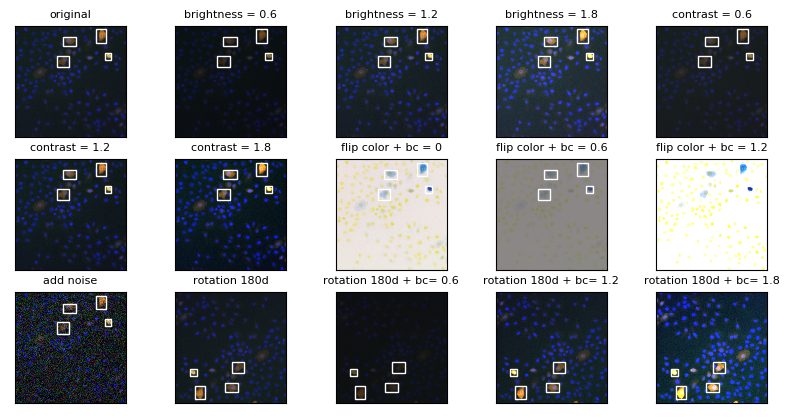


 file: o-1bd92f1fdd1e4ba0817a8b9202dd39b9
iteration: 41

 file: o-8aeba2dcf232409784e6cbec743a8e52
iteration: 42

 file: o-798a522555d84b0cbaf8c9f021784e7f
iteration: 43

 file: o-6e0d9b97264c46b8a2fcd313f6de16a5
iteration: 44

 file: o-c02571a4af194cd8898a2cedbcbdba6d
iteration: 45

 file: o-d766140594064838ad03f1bf4157d0c0
iteration: 46

 file: o-4ef3a2d5602f41cd9760189493fdbc73
iteration: 47

 file: o-aa9931ba8fa6416eb01b6d13ae29cd21
iteration: 48

 file: o-bc6a280676604cf3a129f4466d5dd38e
iteration: 49

 file: o-8534388a8fe04a65a019957e11ec22fa
iteration: 50

 file: o-fd8cfc931fc444ee8bacfb72e8e6c295
iteration: 51

 file: o-446ad5f7cd5344a3a42a4e4067323393
iteration: 52

 file: o-d142889cae7b40bd865dd51b949a8cd3
iteration: 53

 file: o-2aa3e30423cf4712949713d6bd8789f2
iteration: 54

 file: o-68360aa25cff4a9e8bb5991c1d0385b6
iteration: 55

 file: o-6baf452292274134b30eb08e832a74b7
iteration: 56

 file: o-71ae342648894eed9dc52622f269afad
iteration: 57

 file: o-50a638254a51442c9ed68

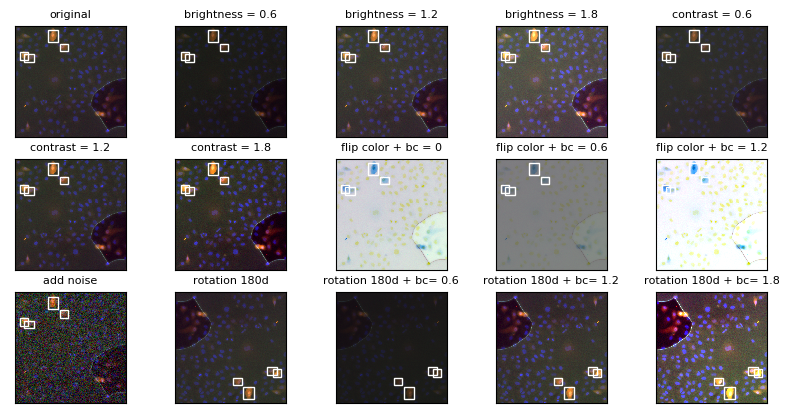


 file: o-348ceb9566a44f6cb91e40a2b8cf0658
iteration: 61

 file: o-6ac3cca1d3134974a0b6ff342d14fd28
iteration: 62

 file: o-008fd610627047dab354a3f716063503
iteration: 63

 file: o-7598ec672d7f487195a7ab9197bce711
iteration: 64

 file: o-7a64e5aef8474fafa8a284cf1a0cccb5
iteration: 65

 file: o-93e14a14c5854b5f815d97adb174ec0e
iteration: 66

 file: o-8650bc1ffc3a49bca30e6eb21d6abd44
iteration: 67

 file: o-5f4e1cede3864ddcbaeb3bb4f4789f14
iteration: 68

 file: o-c52d12fcc363465f8d51430da3346f5d
iteration: 69

 file: o-7633d8b70edb4bf38dc060d6aaf9f43c
iteration: 70

 file: o-6b2857a5d4324906a291aac461bf85e7
iteration: 71

 file: o-a6269b7730734ba98db26994aa8be2cd
iteration: 72

 file: o-76479ffc21b54d04b2d8fef3fb1a26ab
iteration: 73

 file: o-b2cc89a790ea4e79a3c9d9c2b09b147c
iteration: 74

 file: o-7f6f226993124f5c8acd1ebdb8e0cf83
iteration: 75

 file: o-1e994d8807e34e2a975b8d62dbfa4a4c
iteration: 76

 file: o-15067467e8124e108e3a41460d4835ff
iteration: 77

 file: o-2c1c3e46a7354ee49ac76

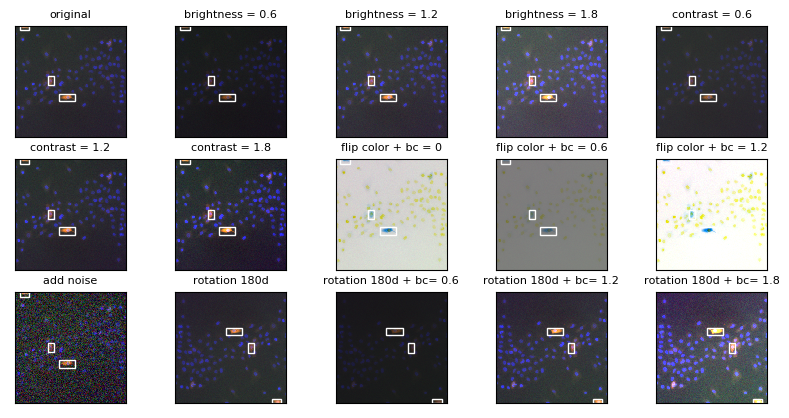


 file: o-e4664ea1b47e4833a7fd7bde1c04440e
iteration: 81

 file: o-818ade2f13bb4ec9a3233a45c6026bb0
iteration: 82

 file: o-377dee25ec944df9bc9f510a7154c30e
iteration: 83

 file: o-7661dc78d7164014bbb963a9efed8bb9
iteration: 84

 file: o-3f4b62fb9b04401aa6ef92ed08423453
iteration: 85

 file: o-74f06f467e1749e8b7aeb1ef1ece9a0b
iteration: 86

 file: o-3f558a30d83e4fbe86aa456e182a3f07
iteration: 87

 file: o-2c5bd9ca32714ad0ad24c9a1ce622eb9
iteration: 88

 file: o-58b248bb2cec44e5ad7037fff063526f
iteration: 89

 file: o-e9796f241c0d4c709f1587ff1bfcb143
iteration: 90

 file: o-a9362a601f67477ea9199f854b68801b
iteration: 91

 file: o-9ff930ee37fc42c3a92053434d8cc3ea
iteration: 92

 file: o-619c84a5f515444cbfe60e125eef4f7b
iteration: 93

 file: o-58c4411ffe80456db96e59cec80d0b2b
iteration: 94

 file: o-c15f881ffd354e889611ae915376cc1d
iteration: 95

 file: o-8dfe61bd976f4cbd8d0ff62b8100322e
iteration: 96

 file: o-27776c5478544ea4bdcc31722452c384
iteration: 97

 file: o-a44afc59f17e45eeb8901

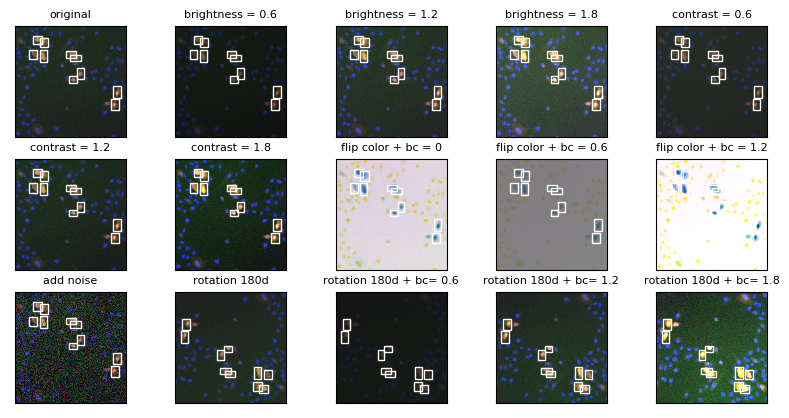


 file: o-f674ca8fc0f24554a10fc457124a4e8d
iteration: 101

 file: o-fb8f25b4cb3b4b65804bcbaedae192f0
iteration: 102

 file: o-dbf1026ba7f94dc4aa7e480d287e084c
iteration: 103

 file: o-6d547c1a476a4b56a34ef534fa379e88
iteration: 104

 file: o-9a9f5d7ad8a04c75ad9765f6ad405b4c
iteration: 105

 file: o-7f178557c8164dc0b8bc0013c6fcba06
iteration: 106

 file: o-c90d6ccfa412423fa49363b87f4e8706
iteration: 107

 file: o-2395db45f6f142c7a41c6d9cd703d97a
iteration: 108

 file: o-44305b1c763d432788fcbe68038a4681
iteration: 109

 file: o-b84669e6c077458f8d54e18c0fabe960
iteration: 110

 file: o-6f4bba3e30e24322966b41e68afa8203
iteration: 111

 file: o-b0c41d67a1a04482934ecbb9fb87a5ee
iteration: 112

 file: o-6519422711584b858fa935015d539d7f
iteration: 113

 file: o-ced85a99a2d44570b93724054ffa1e8f
iteration: 114

 file: o-e0d0bb20f56942a9bee6d9d9b5e7a2c5
iteration: 115

 file: o-779616d087424e3598100a0f9a06483e
iteration: 116

 file: o-fb0c829d3a024e2a8df6a947cfb37975
iteration: 117

 file: o-8b50

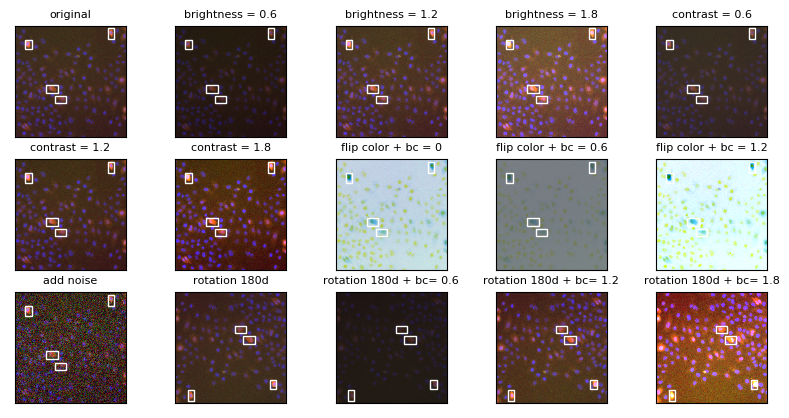


 file: o-3d244fb72f1840e186dbb634f9f3c219
iteration: 121

 file: o-2016cb3ca9b849859ef01fa56b49d833
iteration: 122

 file: o-0806796b4d1948a3a658006754fb3f65
iteration: 123

 file: o-2b863568c23d4ba28d2c27de49a2a7a9
iteration: 124

 file: o-84cc86174b6748c5bf4af15ffa6d5dda
iteration: 125

 file: o-f5dd5bfb002a4359a38311a39426b69f
iteration: 126

 file: o-71916403b6f44e3492ba8aff59df912e
iteration: 127

 file: o-51de745e5eed4c28a0c4be0aa0d379a9
iteration: 128

 file: o-470a601b4ca14a54977b580466770bfb
iteration: 129

 file: o-21347684342249d1aee35d7a234842e3
iteration: 130

 file: o-f54829baf5ba4a94a16569f70d0608a1
iteration: 131

 file: o-c31240915e9c45ed95d9fa83f027d40e
iteration: 132

 file: o-424f371276974c5eac069e422b507947
iteration: 133

 file: o-230eeea57d804e5bb2393f9c97f67c6d
iteration: 134

 file: o-9cd9d7e0f9cf44f9a8cb768deb38f4fa
iteration: 135

 file: o-23ecb1738e3c4697a2846f2191da8cc5
iteration: 136

 file: o-074c5f7b727744ee80e4eec3134e3e6d
iteration: 137

 file: o-2342

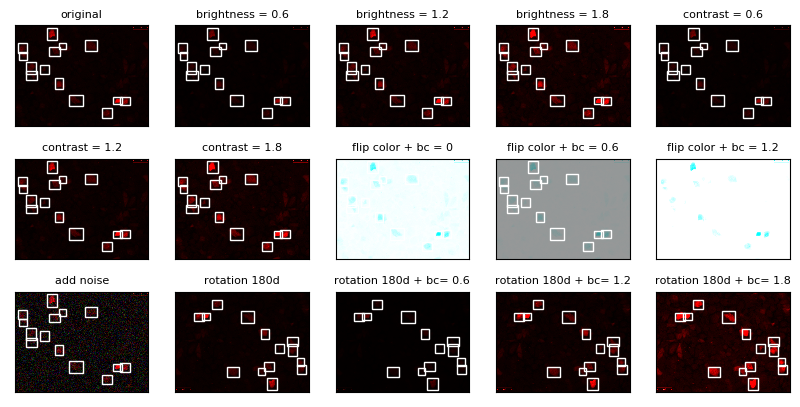


 file: o-d3982c3408c84144b20ddd03a3458c44
iteration: 141

 file: o-c4d0255d1396491584a51323400b39c3
iteration: 142

 file: o-bb62637c28054242b594632e6557b103
iteration: 143

 file: o-df3b211f62a54bc09847bb36dbd427b0
iteration: 144

 file: o-dcedfca53dbf4afea707f526436b4257
iteration: 145

 file: o-703e8579503d49e089863e1a4ab72ffc
iteration: 146

 file: o-db4a780c771a4d08824eb83bf976c520
iteration: 147


In [0]:
# finally, transform images

plot_interval = 20
work_dir = 'images/'
dest_dir = 'transformed_images/'
df_transformed = pd.DataFrame()
df_rotated = pd.DataFrame()

for i, image_id in enumerate(d['image_id'].unique()):
  loc_mask = (d['image_id'] == image_id) # for slicing dataframe later
  df_originalBboxes = d.loc[loc_mask, :].drop('image_id', axis=1).reset_index(drop=True)
  print(f'\n file: {image_id}')
  print(f'iteration: {i}')

  # (1.0) load image and get its parameters
  img = cv2.imread(f'{work_dir}{image_id}.jpg', -1)
  img_height, img_width, img_channel = img.shape
  
  if i % plot_interval == 0:
    img_list = []
    title_list = []
    img_list.append(img)
    title_list.append('original')

  # (1.1) adjust brightness
  for bright in [0.6, 1.2, 1.8]:
    img_bright = brightness_contrast_aug(img, bright_coeff=bright)
    cv2.imwrite(f'transformed_images/{image_id}-bright-{bright}.jpg', img_bright)

    df_bright = df_originalBboxes.copy()
    df_bright['image_id'] = image_id + f'-bright-{bright}' 
    df_transformed = df_transformed.append(df_bright, ignore_index = True)

    if i % plot_interval == 0:
       img_list.append(img_bright)
       title_list.append(f'brightness = {bright}')
  
  # (1.2) adjust contrast
  #df_contra = pd.DataFrame()
  for contra in [0.6, 1.2, 1.8]:
    img_contra = brightness_contrast_aug(img, cont_coeff=contra)
    cv2.imwrite(f'transformed_images/{image_id}-contra-{contra}.jpg', img_contra)

    df_contra = df_originalBboxes.copy()
    df_contra['image_id'] = image_id + f'-contra-{contra}' 
    df_transformed = df_transformed.append(df_contra, ignore_index = True)

    if i % plot_interval == 0:
       img_list.append(img_contra)
       title_list.append(f'contrast = {contra}')

  # (1.3) flip color + bc
  #df_flipcolor = pd.DataFrame()
  img_flipcolor = Image.fromarray(img.copy())
  img_flipcolor = ImageOps.invert(img_flipcolor)
  img_flipcolor = np.array(img_flipcolor)
  for bc in [0, 0.6, 1.2]:
    if bc == 0:
      img_flipcolor_bc = img_flipcolor
    else:
      img_flipcolor_bc = brightness_contrast_aug(img_flipcolor, cont_coeff=bc, bright_coeff=bc)
    cv2.imwrite(f'transformed_images/{image_id}-flipcolor-bc-{bc}.jpg', img_flipcolor_bc)

    df_flipcolor = df_originalBboxes.copy()
    df_flipcolor['image_id'] = image_id + f'-flipcolor-bc-{bc}' 
    df_transformed = df_transformed.append(df_flipcolor, ignore_index = True)

    if i % plot_interval == 0:
       img_list.append(img_flipcolor_bc)
       title_list.append(f'flip color + bc = {bc}')

  # (1.5) add noise
  noise =  np.random.normal(loc=0, scale=1, size=img.shape)
  img_noisy = np.clip((img.copy()/255.0 + noise*0.1),0,1)
  cv2.imwrite(f'transformed_images/{image_id}-noisy.jpg', img_noisy)

  df_noisy = df_originalBboxes.copy()
  df_noisy['image_id'] = image_id + '-noisy' 
  df_transformed = df_transformed.append(df_noisy, ignore_index = True)

  if i % plot_interval == 0:
    img_list.append(img_noisy)
    title_list.append('add noise')

  # (2.0) rotation
  df_bboxes = df_originalBboxes.iloc[:, 6:]
  img_rotate, df_newBboxes = rotate(img.copy(), 180, df_bboxes)
  cv2.imwrite(f'rotated_images/{image_id}-rotate.jpg', img_rotate)
  
  df_bboxes_rotate = df_newBboxes.copy()
  df_bboxes_rotate['image_id'] = image_id + '-rotate' 
  df_rotated = df_rotated.append(df_bboxes_rotate, ignore_index = True)
  
  if i % plot_interval == 0:
    img_list.append(img_rotate)
    title_list.append('rotation 180d')


  # (2.1) rotation + bc
  #df_rotate3d_bc = pd.DataFrame()
  for bc in [0.6, 1.2, 1.8]:
    bc = np.round(bc, 2)
    img_rotate_bc = brightness_contrast_aug(img_rotate, cont_coeff=bc, bright_coeff=bc)
    cv2.imwrite(f'rotated_images/{image_id}-rotate-bc-{bc}.jpg', img_rotate_bc)

    df_bboxes_rotate_bc = df_newBboxes.copy()
    df_bboxes_rotate_bc['image_id'] = image_id + f'-rotate-bc-{bc}'
    df_rotated = df_rotated.append(df_bboxes_rotate_bc, ignore_index = True)

    if i % plot_interval == 0:
      img_list.append(img_rotate_bc)
      title_list.append(f'rotation 180d + bc= {bc}')

  # plot the original and transformed images w/ bboxes
  if i % plot_interval == 0:
    # set up the plotting area
    num_plot = len(img_list)
    n_col = 5
    if num_plot%n_col == 0:
      n_row = num_plot//n_col
    else:
      n_row = num_plot//n_col +1

    ax_index = []
    for i in range(n_row):
      for j in range(n_col):
        ax_index.append([i,j])

    # plotting
    fig, axs = plt.subplots(n_row, n_col, figsize=(10,5), dpi=100)

    for c, i in enumerate(img_list):
      ax = ax_index[c]
      
      axs[ax[0], ax[1]].imshow(i[:,:,[2,1,0]])
      axs[ax[0], ax[1]].set_title(title_list[c], size=8)
      axs[ax[0], ax[1]].get_xaxis().set_ticks([])
      axs[ax[0], ax[1]].get_yaxis().set_ticks([])

      # draw bboxes
      if 'rotation' in title_list[c]:
        bbox_df = df_bboxes_rotate
      else:
        bbox_df = df_originalBboxes

      for i in range(len(bbox_df)):
        rect = draw_rectangles(i, img_height, img_width, bbox_df)
        axs[ax[0], ax[1]].add_patch(rect)
      
    plt.show(); plt.close()

In [0]:
!ls transformed_images | wc -l
!ls rotated_images | wc -l

print(len(df_transformed))
print(len(df_rotated))

1480
592
7520
3008


In [0]:
df_rotated.head()

x1  ...                                          image_id
0  355.746104  ...         o-7023f07428e642bbbdb5a886a7f93358-rotate
1  355.746104  ...  o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-0.6
2  355.746104  ...  o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-1.2
3  355.746104  ...  o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-1.8
4  242.859627  ...         o-cd9a98df36794c3db7cbadda31c20745-rotate

[5 rows x 7 columns]

In [0]:
x_col = []
y_col = []
w_col = []
h_col = []

for i in range(len(df_rotated)):
  x_col.append(df_rotated.x1[i]/df_rotated.img_w[i])
  y_col.append(df_rotated.y1[i]/df_rotated.img_h[i])
  w_col.append(abs(df_rotated.x2[i] - df_rotated.x1[i])/df_rotated.img_w[i])
  h_col.append(abs(df_rotated.y2[i] - df_rotated.y1[i])/df_rotated.img_h[i])

df_xywh = pd.DataFrame(np.column_stack([x_col, y_col, w_col, h_col]), 
                               columns=['x', 'y', 'w', 'h'])
print(df_xywh.head(10))

          x         y         w         h
0  0.395273  0.254658  0.078037  0.068975
1  0.395273  0.254658  0.078037  0.068975
2  0.395273  0.254658  0.078037  0.068975
3  0.395273  0.254658  0.078037  0.068975
4  0.269844  0.220234  0.094972  0.117318
5  0.249360  0.063809  0.124767  0.081937
6  0.127079  0.864778  0.090131  0.075475
7  0.202805  0.609433  0.076350  0.070764
8  0.576227  0.495241  0.069060  0.075727
9  0.269844  0.220234  0.094972  0.117318


In [0]:
df_rotated_all = pd.concat([df_rotated, df_xywh], axis=1, sort=False)
print(df_rotated_all.head(10))

           x1          y1          x2  ...         y         w         h
0  355.746104  229.192443  425.979692  ...  0.254658  0.078037  0.068975
1  355.746104  229.192443  425.979692  ...  0.254658  0.078037  0.068975
2  355.746104  229.192443  425.979692  ...  0.254658  0.078037  0.068975
3  355.746104  229.192443  425.979692  ...  0.254658  0.078037  0.068975
4  242.859627  198.210539  328.334490  ...  0.220234  0.094972  0.117318
5  224.423884   57.428426  336.714390  ...  0.063809  0.124767  0.081937
6  114.371491  778.299885  195.489270  ...  0.864778  0.090131  0.075475
7  182.524419  548.489880  251.239500  ...  0.609433  0.076350  0.070764
8  518.604038  445.717315  580.758065  ...  0.495241  0.069060  0.075727
9  242.859627  198.210539  328.334490  ...  0.220234  0.094972  0.117318

[10 rows x 11 columns]


In [0]:
df_rotated_all.to_csv('rotated_cell_obj_id_bbox.csv', index=False)
df_transformed.to_csv('transformed_cell_obj_id_bbox.csv', index=False)

In [0]:
!cp rotated_cell_obj_id_bbox.csv drive/My\ Drive/data_augmentation/
!cp transformed_cell_obj_id_bbox.csv drive/My\ Drive/data_augmentation/

In [0]:
df_rotated_all['image_id'].head

<bound method NDFrame.head of 0              o-7023f07428e642bbbdb5a886a7f93358-rotate
1       o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-0.6
2       o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-1.2
3       o-7023f07428e642bbbdb5a886a7f93358-rotate-bc-1.8
4              o-cd9a98df36794c3db7cbadda31c20745-rotate
                              ...                       
3003    o-db4a780c771a4d08824eb83bf976c520-rotate-bc-1.8
3004    o-db4a780c771a4d08824eb83bf976c520-rotate-bc-1.8
3005    o-db4a780c771a4d08824eb83bf976c520-rotate-bc-1.8
3006    o-db4a780c771a4d08824eb83bf976c520-rotate-bc-1.8
3007    o-db4a780c771a4d08824eb83bf976c520-rotate-bc-1.8
Name: image_id, Length: 3008, dtype: object>

In [0]:
# compress /images/ into a zip file
!zip -r transformed_images.zip transformed_images/
!zip -r rotated_images.zip rotated_images/

updating: transformed_images/ (stored 0%)
  adding: transformed_images/o-76479ffc21b54d04b2d8fef3fb1a26ab-contra-1.2.jpg (deflated 1%)
  adding: transformed_images/o-a820ba5da0224a099fb7b1ecbb53adf6-flipcolor-bc-0.6.jpg (deflated 1%)
  adding: transformed_images/o-58c4411ffe80456db96e59cec80d0b2b-flipcolor-bc-0.6.jpg (deflated 1%)
  adding: transformed_images/o-44305b1c763d432788fcbe68038a4681-flipcolor-bc-0.6.jpg (deflated 1%)
  adding: transformed_images/o-15067467e8124e108e3a41460d4835ff-contra-0.6.jpg (deflated 1%)
  adding: transformed_images/o-1e994d8807e34e2a975b8d62dbfa4a4c-noisy.jpg (deflated 91%)
  adding: transformed_images/o-5f4e1cede3864ddcbaeb3bb4f4789f14-flipcolor-bc-1.2.jpg (deflated 1%)
  adding: transformed_images/o-6f4bba3e30e24322966b41e68afa8203-flipcolor-bc-0.6.jpg (deflated 2%)
  adding: transformed_images/o-27776c5478544ea4bdcc31722452c384-flipcolor-bc-0.6.jpg (deflated 2%)
  adding: transformed_images/o-3f4b62fb9b04401aa6ef92ed08423453-contra-1.2.jpg (deflated 

In [0]:
# copy files to Google Drive
!cp transformed_images.zip drive/My\ Drive/data_augmentation/
!cp rotated_images.zip drive/My\ Drive/data_augmentation/

## Old codes for testing only


o-7023f07428e642bbbdb5a886a7f93358
iteration: 0


 original:


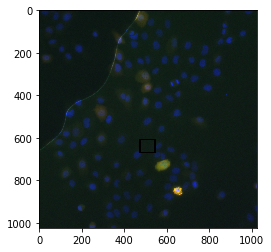


 brightness: 0.1


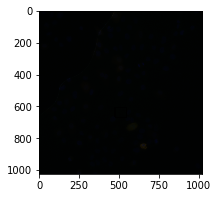


 brightness: 0.5


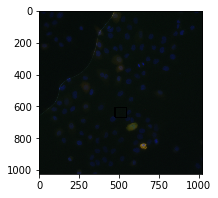


 brightness: 0.9


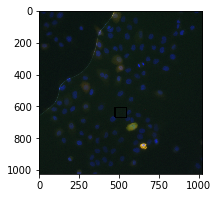


 contrast: 0.1


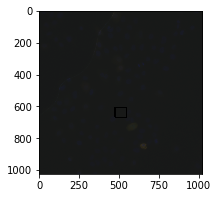


 contrast: 0.5


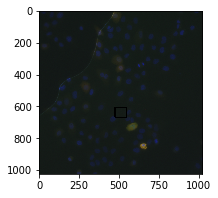


 contrast: 0.9


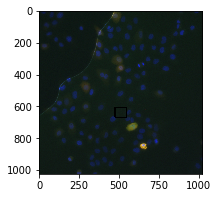


 flip color:


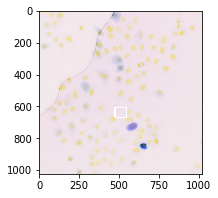


 flip color:


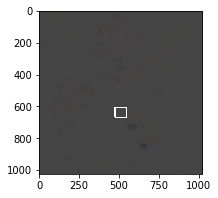


 flip color:


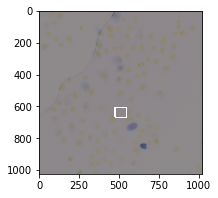

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 add gaussian noise:


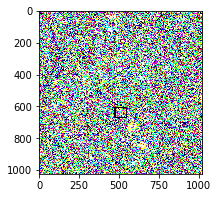

180


NameError: ignored

In [0]:
# transform images (Werner's codes)
plot_interval = 20
work_dir = 'images/'
df_proc_all = pd.DataFrame()

for i, image_id in enumerate(d['image_id'].unique()):
  print(image_id)
  print(f"iteration: {i}\n")
  # if i == 0: continue
  img = cv2.imread(f"{work_dir}{image_id}.jpg")[:,:,::-1] # opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
  img_h, img_w, img_c = img.shape

  bboxes_per_image = d.loc[d['image_id'] == image_id, ['x1', 'y1', 'x2', 'y2', 'tag_int']].to_numpy()

  # plot the image w/ bboxes
  if i % plot_interval == 0:
    print("\n original:")
    plotted_img = draw_rect(img, bboxes_per_image, color=[0, 0, 0]) # bboxes_per_tag, messi_bboxes
    plt.figure(figsize=(8, 4)); plt.imshow(plotted_img); plt.xticks([]), plt.yticks([])
    plt.show(); plt.close()


  # (1.1) brightness
  df_bright = pd.DataFrame()
  for bright in np.linspace(0.1, 0.9, 3):
    img_bright = brightness_contrast_aug(img, bright_coeff=bright)
    if i % plot_interval == 0:
      print(f"\n brightness: {bright}")
      plotted_img = draw_rect(img_bright, bboxes_per_image, color=[0, 0, 0])
      plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
    df_bright = pd.concat([df_bright,
                           create_bboxes_df(image_id, img_w, img_h, bboxes_per_image, columns, f'bright-{bright}')])
    cv2.imwrite(f'transfomred_images/{image_id}-bright-{bright}.jpg', img_bright)


  # (1.2) contrast
  df_contra = pd.DataFrame()
  for contra in np.linspace(0.1, 0.9, 3):
    img_contra = brightness_contrast_aug(img, cont_coeff=contra)
    if i % plot_interval == 0:
      print(f"\n contrast: {contra}")
      plotted_img = draw_rect(img_contra, bboxes_per_image, color=[0, 0, 0])
      plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
    df_contra = pd.concat([df_contra,
                           create_bboxes_df(image_id, img_w, img_h, bboxes_per_image, columns, f'contra-{contra}')])
    cv2.imwrite(f'transfomred_images/{image_id}-contra-{contra}.jpg', img_contra)


#   # (1.3) brightness/contrast
#   for bc in np.linspace(0.1, 0.9, 3):
#     img_bc = brightness_contrast_aug(img, cont_coeff=bc, bright_coeff=bc)
#     # plot contrast result
#     if i % plot_interval == 0:
#         print("\n brightness / contrast: {bc}")
#         plotted_img = draw_rect(img_bc, bboxes_per_image, color=[0, 0, 0])
#         plt.figure(figsize=(10, 5)); plt.imshow(plotted_img); plt.show(); plt.close()
#     # save image
#     cv2.imwrite(f'transfomred_images/{image_id}-bc-{bc}.jpg', img_bc)
#     # create df
#     df_bc = create_bboxes_df(image_id, img_w, img_h, bboxes_per_image, columns, 'bc')


  # (1.4) flip color + bc
  img_flipcolor = Image.fromarray(img.copy())
  img_flipcolor = ImageOps.invert(img_flipcolor)
  img_flipcolor = np.array(img_flipcolor)
  df_flipcolor = pd.DataFrame()
  for bc in [0, 0.3, 0.6]:
    if bc == 0:
      img_flipcolor_bc = img_flipcolor
    else:
      img_flipcolor_bc = brightness_contrast_aug(img_flipcolor, cont_coeff=bc, bright_coeff=bc)
    # plot
    if i % plot_interval == 0:
        print("\n flip color:")
        plotted_img = draw_rect(img_flipcolor_bc, bboxes_per_image, color=[255, 255, 255])
        plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
    df_flipcolor = pd.concat([df_flipcolor,
                              create_bboxes_df(image_id, img_w, img_h, bboxes_per_image, columns, f'flipcolor-bc-{bc}')])
    cv2.imwrite(f'transfomred_images/{image_id}-flipcolor-bc-{bc}.jpg', img_flipcolor_bc)


  # (1.5) add gaussian noise
  mean=0; var=0.1; sigma=var**0.5
  gauss = np.random.normal(mean, sigma, (img_h, img_w, img_c))
  gauss = gauss.reshape(img_h, img_w, img_c) * img.max()
  img_noisy = img + gauss
  # plot
  if i % plot_interval == 0:
      print("\n add gaussian noise:")
      plotted_img = draw_rect(img_noisy, bboxes_per_image, color=[0, 0, 0])
      plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
  df_noisy = create_bboxes_df(image_id, img_w, img_h, bboxes_per_image, columns, f'noisy')
  cv2.imwrite(f'transfomred_images/{image_id}-noisy.jpg', img_noisy)


#     # (2.0) horizontal flip, mirror
#     img_horz, bboxes_horz = RandomHorizontalFlip(1)(img.copy(), bboxes_per_image.copy())
#     # plot horz result
#     if i % plot_interval == 0:
#         print("\nhorizontal flip:")
#         plotted_img = draw_rect(img_horz, bboxes_horz, color=[0, 0, 0])
#         plt.figure(figsize=(10, 5)); plt.imshow(plotted_img); plt.show(); plt.close()
#     # save the processed
#     cv2.imwrite(f'manga_images_processed/{image_id}-horz.jpg', img_horz)
#     # create dataframe for processed image bboxes
#     df_horz = create_bboxes_df(image_id, img_w, img_h, bboxes_horz, columns, 'horz')


  # (3.0) rotation
  img_rotate3d, bboxes_rotate3d = Rotate(180)(img.copy(), bboxes_per_image.copy())
  # plot rotated 3 degree result
  if i % plot_interval == 0:
      print("\n rotation 180 degree:")
      plotted_img = draw_rect(img_rotate3d, bboxes_rotate3d, color=[0, 0, 0])
      plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
  df_rotate3d = create_bboxes_df(image_id, img_w, img_h, bboxes_rotate3d, columns, 'rotate3d')
  cv2.imwrite(f'transfomred_images/{image_id}-rotate3d.jpg', img_rotate3d)
  


  # (3.1) rotation + brightness/ contrast
  df_rotate3d_bc = pd.DataFrame()
  for bc in np.linspace(0.3, 0.9, 3):
    bc = np.round(bc, 2)
    img_rotate3d_bc = brightness_contrast_aug(img_rotate3d, cont_coeff=bc, bright_coeff=bc)
    # plot
    if i % plot_interval == 0:
        print("\n rotation 180 degree + bc enhance:")
        plotted_img = draw_rect(img_rotate3d_bc, bboxes_rotate3d, color=[0, 0, 0])
        plt.figure(figsize=(6, 3)); plt.imshow(plotted_img); plt.show(); plt.close()
    df_rotate3d_bc = pd.concat([df_rotate3d_bc,
                                create_bboxes_df(image_id, img_w, img_h, bboxes_rotate3d, columns, f'rotate3d-bc-{bc}')])
    cv2.imwrite(f'transfomred_images/{image_id}-rotate3d-bc-{bc}.jpg', img_rotate3d_bc)


  # save processed bboxes
  df_processed = pd.concat([df_bright, df_contra, df_flipcolor,
                            df_noisy, df_rotate3d, df_rotate3d_bc])
  df_processed = df_processed.reset_index().drop(['index'], axis=1)
  df_proc_all = pd.concat([df_proc_all, df_processed])
  
  # if i >= plot_interval: break
        
df_proc_all.to_csv('transformed_cell_obj_id_bbox.csv', index=False)

In [0]:
get_co

In [0]:
# taken from data_aug.py
# with the intention of not having had to import data_aug in the future
def Rotate(angle, img, df_bboxes):
    """Rotates an image    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Arg
    ----------
    angle: float
        The angle by which the image is to be rotated 
        
    img: input img to be flipped
        cv2 object

    bboxes
        bounding box coordinates of the input image

    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box """
        
    w,h = img.shape[1], img.shape[0]
    cx, cy = w//2, h//2
    bboxes = df_bboxes.to_numpy() # convert df to numpy array
    corners = get_corners(bboxes)
    corners = np.hstack((corners, bboxes[:,4:]))
    img = rotate_im(img, angle)    
    corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
         
    new_bbox = get_enclosing_box(corners)
        
    scale_factor_x = img.shape[1] / w
    scale_factor_y = img.shape[0] / h
        
    img = cv2.resize(img, (w,h))
        
    new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        
    bboxes  = new_bbox
    bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    newBboxes_df = pd.DataFrame(data = bboxes[0:, 0:],
                                index = [i for i in range(bboxes.shape[0])],
                                columns = ['x1','y1','x2','y2','img_h','img_w'])
        
    return img, newBboxes_df